https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from helpers.outliers import MyOutliers
from helpers.feature_engineering import makeBinaryClassification, getUniqueValuesPerFeature
from sklearn.model_selection import train_test_split
from helpers.plot_helper import plotDistsPerClass, plotBothDists
from flights_delay.feature_prev_delays import FeaturePrevDelays
from flights_delay.feature_airline_delays import FeatureAirlineDelays
from helpers.my_one_hot_encoder import MyOneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
from sklearn.dummy import DummyClassifier
from helpers.feature_engineering import dateStrToDayYear, getMappingOfSimilarCategoricalColumns, \
    compareSimilarCategoricalColumns 
from helpers.my_one_hot_encoder import MyOneHotEncoder
from helpers.py_helpers import is_number
from scipy.stats import skew, kurtosis
from helpers.outliers import MyOutliers
from sklearn.preprocessing import StandardScaler
from helpers.plot_helper import scatter_2d_label
from sklearn.decomposition import PCA # Import the PCA module
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions
from sklearn.metrics import f1_score, precision_score
from sklearn.manifold import Isomap
from helpers.performance_issues import subsample_keeping_class_proportions, rbfPCAkernel
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from matplotlib.colors import ListedColormap
from flights_delay.flight_delay_scoring import printFlightDelayScores, getFlightDelayScores
from helpers.my_cross_validation import MyCrossValidation
from sklearn.metrics import log_loss
from helpers.performance_issues import processSeparately
from helpers.plot_helper import scatter_2d_label, plotGPoptFunction, plotGPoptConvergence
from flights_delay.flight_delay_scoring import getScore_onKFold_callback, scoreWithDimReduction
from flights_delay.dataset import getRbfKernelPCADimReducedDataset
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
from time import time, sleep
from sklearn.linear_model import LogisticRegression

In [4]:
plt.style.use('classic')
plt.rc("figure", facecolor="white")

In [5]:
random_state = 0 # Ensure reproducible results

In [6]:
data_relative_path = '../Data'

In [7]:
target_col = 'IS_DELAYED'

In [8]:
n_jobs = 4

# Flying to New York City - Classifying

In [9]:
path_data = os.path.realpath(os.path.join(os.getcwd(), data_relative_path, 'train_data_v2_engineered.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/train_data_v2_engineered.csv'

In [10]:
df = pd.read_csv(path_data, delimiter = ',', header=0)
df.shape

(31186, 43)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31186 entries, 0 to 31185
Data columns (total 43 columns):
QUARTER               31186 non-null int64
MONTH                 31186 non-null int64
DAY_OF_MONTH          31186 non-null int64
DAY_OF_WEEK           31186 non-null int64
DEP_TIME              31186 non-null float64
DEP_DELAY             31186 non-null float64
DEP_DELAY_NEW         31186 non-null float64
DEP_DEL15             31186 non-null float64
DEP_DELAY_GROUP       31186 non-null float64
CRS_ELAPSED_TIME      31186 non-null float64
PREV_DELAYS_30        31186 non-null float64
PREV_DELAYS_60        31186 non-null float64
PREV_DELAYS_120       31186 non-null float64
PREV_DELAYS_180       31186 non-null float64
PREV_DELAYS_360       31186 non-null float64
PREV_DELAYS_720       31186 non-null float64
AIRLINE_DELAYS_30     31186 non-null float64
AIRLINE_DELAYS_60     31186 non-null float64
AIRLINE_DELAYS_120    31186 non-null float64
AIRLINE_DELAYS_180    31186 non-null float64

In [12]:
df.sample(10, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,CRS_ELAPSED_TIME,...,ORIGIN_3,ORIGIN_4,ORIGIN_5,DEST_0,DEST_1,DEST_2,DEST_3,DEST_4,DEST_5,IS_DELAYED
4696,0,1,0,1,1358.878788,-6.0,0.0,0.0,-1.0,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
22712,0,0,0,0,667.878788,68.0,68.0,1.0,4.0,398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True
959,1,1,0,0,1388.878788,9.0,9.0,0.0,0.0,133.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
3668,1,1,0,0,1170.878788,81.0,81.0,1.0,5.0,137.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
24321,1,1,0,0,400.878788,-9.0,0.0,0.0,-1.0,66.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,False
2887,0,0,0,0,1194.878788,7.0,7.0,0.0,0.0,173.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
12034,0,0,1,0,1859.878788,70.0,70.0,1.0,4.0,168.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
13019,0,0,1,0,955.878788,131.0,131.0,1.0,8.0,131.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True
15102,0,0,0,0,390.878788,-4.0,0.0,0.0,-1.0,130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False
15423,0,0,1,0,1271.878788,82.0,82.0,1.0,5.0,192.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True


In [13]:
XX = df.drop(labels=[target_col], axis=1)
yy = df[target_col]
XX.shape, yy.shape

((31186, 42), (31186,))

In [14]:
columns_one_hot_encoded = np.array([col for col in df.columns if is_number(col[-1])])
columns_not_one_hot = np.array([col for col in df.columns if not is_number(col[-1])])

In [15]:
df[columns_not_one_hot].describe()

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DELAY_GROUP,CRS_ELAPSED_TIME
count,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000,31186.000000
mean,0.268903,0.285449,0.173988,0.328898,1070.573074,19.281953,21.085840,0.751812,238.534631
std,0.443396,0.451635,0.379106,0.469820,506.387802,32.605802,31.302126,2.237086,111.624021
min,0.000000,0.000000,0.000000,0.000000,178.878788,-20.000000,0.000000,-2.000000,59.000000
25%,0.000000,0.000000,0.000000,0.000000,605.878788,-3.000000,0.000000,-1.000000,140.000000
50%,0.000000,0.000000,0.000000,0.000000,1078.878788,2.000000,2.000000,0.000000,177.000000
75%,1.000000,1.000000,0.000000,1.000000,1482.628788,34.000000,34.000000,2.000000,341.000000
max,1.000000,1.000000,1.000000,1.000000,2297.878788,132.000000,132.000000,8.000000,468.000000


### Dummy Classifier

In [16]:
dc = DummyClassifier(random_state=random_state).fit(XX, yy)
dc.score(XX, yy)

0.49785160007695761

In [17]:
dummy_preds = dc.predict(XX)
printFlightDelayScores(y_true=yy, y_pred=dummy_preds)

precision score for delayed flights: 0.498662420382
f1 score for both classes: [ 0.49571714  0.49996807]
f1 score for is_delayed true class: 0.499968069481
f1 score with weighted average: 0.497846011409
f1 score with unweighted average: 0.497842603685


In [18]:
log_loss(y_true = yy, y_pred = dc.predict_proba(XX))

17.343591302004143

## Naive Bayes

In [19]:
clf = GaussianNB()

In [20]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [21]:
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
scores

precision_score            0.847233
f1_score_nondelayed        0.809183
f1_score_delayed           0.779077
f1_score_weighted_avg      0.794136
f1_score_unweighted_avg    0.794130
log_loss                   2.740051
accuracy_score             0.795261
dtype: float64

## Quadratic Discriminant Classifier

In [22]:
clf = QuadraticDiscriminantAnalysis()

In [23]:
cv = MyCrossValidation(n_folds=10, random_state=random_state)

In [24]:
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
scores

/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


precision_score            0.837377
f1_score_nondelayed        0.798841
f1_score_delayed           0.764298
f1_score_weighted_avg      0.781585
f1_score_unweighted_avg    0.781569
log_loss                   1.850568
accuracy_score             0.783012
dtype: float64

## Random Forest Classifier

In [26]:
%%time
clf = RandomForestClassifier(random_state=random_state)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.864919
f1_score_nondelayed        0.819989
f1_score_delayed           0.788964
f1_score_weighted_avg      0.804486
f1_score_unweighted_avg    0.804476
log_loss                   0.990132
accuracy_score             0.805746
dtype: float64
CPU times: user 4.49 s, sys: 8 ms, total: 4.5 s
Wall time: 4.49 s


## MLP Classifier

In [25]:
%%time
clf = MLPClassifier(random_state=random_state)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.841667
f1_score_nondelayed        0.789279
f1_score_delayed           0.776084
f1_score_weighted_avg      0.782760
f1_score_unweighted_avg    0.782681
log_loss                   0.482232
accuracy_score             0.787436
dtype: float64
CPU times: user 51.7 s, sys: 2min 22s, total: 3min 14s
Wall time: 25.9 s


In [35]:
def gpOptimization(n_jobs=n_jobs, n_folds=10):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (CC, ) = params
        print "current C: {}".format(CC)
        start = time()

        clf = LogisticRegression(C=CC)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        log_loss = scores['log_loss']
        print "current accuracy score: {}".format(score)
        print "current log loss: {}".format(log_loss)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return log_loss #-score
    
    C_space = Real(1e-4, 1e3, prior='log-uniform')
    space  = [C_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [36]:
res_gp = gpOptimization()

current C: 0.694535625742
current accuracy score: 0.818572649866
current log loss: 0.40271532402
time elapsed: 9.29847383499

current C: 10.1467173944
current accuracy score: 0.8183802908
current log loss: 0.40273065672
time elapsed: 9.22016882896

current C: 1.65708059843
current accuracy score: 0.81847638293
current log loss: 0.402720902428
time elapsed: 8.61785697937

current C: 0.651901951282
current accuracy score: 0.81828408556
current log loss: 0.402760477334
time elapsed: 8.42778015137

current C: 0.0923811991681
current accuracy score: 0.818380249669
current log loss: 0.4026773604
time elapsed: 7.58093309402

current C: 0.000100107754792
current accuracy score: 0.8120633515
current log loss: 0.419601153369
time elapsed: 4.01759314537

current C: 1000.0
current accuracy score: 0.818476454909
current log loss: 0.4028291379
time elapsed: 8.24822402

current C: 1000.0
current accuracy score: 0.818476454909
current log loss: 0.4028291379
time elapsed: 7.55689692497

current C: 1000

## Logistic Regression Classifier

In [26]:
%%time
clf = LogisticRegression(random_state=random_state)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.882609
f1_score_nondelayed        0.832268
f1_score_delayed           0.802292
f1_score_weighted_avg      0.817282
f1_score_unweighted_avg    0.817280
log_loss                   0.402703
accuracy_score             0.818541
dtype: float64
CPU times: user 8.18 s, sys: 6.06 s, total: 14.2 s
Wall time: 7.3 s


In [35]:
def gpOptimization(n_jobs=n_jobs, n_folds=10):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (CC, ) = params
        print "current C: {}".format(CC)
        start = time()

        clf = LogisticRegression(C=CC)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        log_loss = scores['log_loss']
        print "current accuracy score: {}".format(score)
        print "current log loss: {}".format(log_loss)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return log_loss #-score
    
    C_space = Real(1e-4, 1e3, prior='log-uniform')
    space  = [C_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [36]:
res_gp = gpOptimization()

current C: 0.694535625742
current accuracy score: 0.818572649866
current log loss: 0.40271532402
time elapsed: 9.29847383499

current C: 10.1467173944
current accuracy score: 0.8183802908
current log loss: 0.40273065672
time elapsed: 9.22016882896

current C: 1.65708059843
current accuracy score: 0.81847638293
current log loss: 0.402720902428
time elapsed: 8.61785697937

current C: 0.651901951282
current accuracy score: 0.81828408556
current log loss: 0.402760477334
time elapsed: 8.42778015137

current C: 0.0923811991681
current accuracy score: 0.818380249669
current log loss: 0.4026773604
time elapsed: 7.58093309402

current C: 0.000100107754792
current accuracy score: 0.8120633515
current log loss: 0.419601153369
time elapsed: 4.01759314537

current C: 1000.0
current accuracy score: 0.818476454909
current log loss: 0.4028291379
time elapsed: 8.24822402

current C: 1000.0
current accuracy score: 0.818476454909
current log loss: 0.4028291379
time elapsed: 7.55689692497

current C: 1000

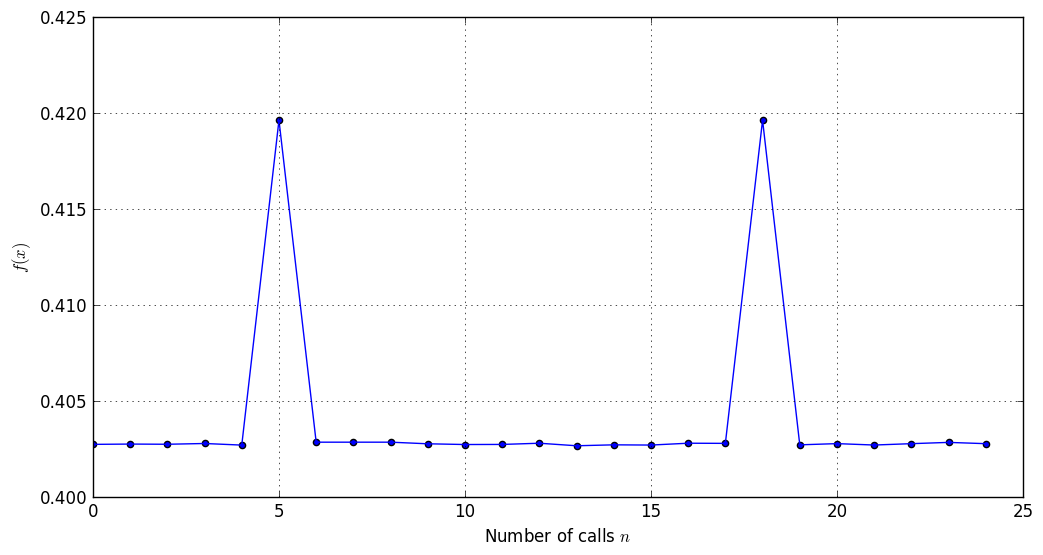

In [37]:
plotGPoptFunction(res_gp)
plt.grid(True)
plt.show()

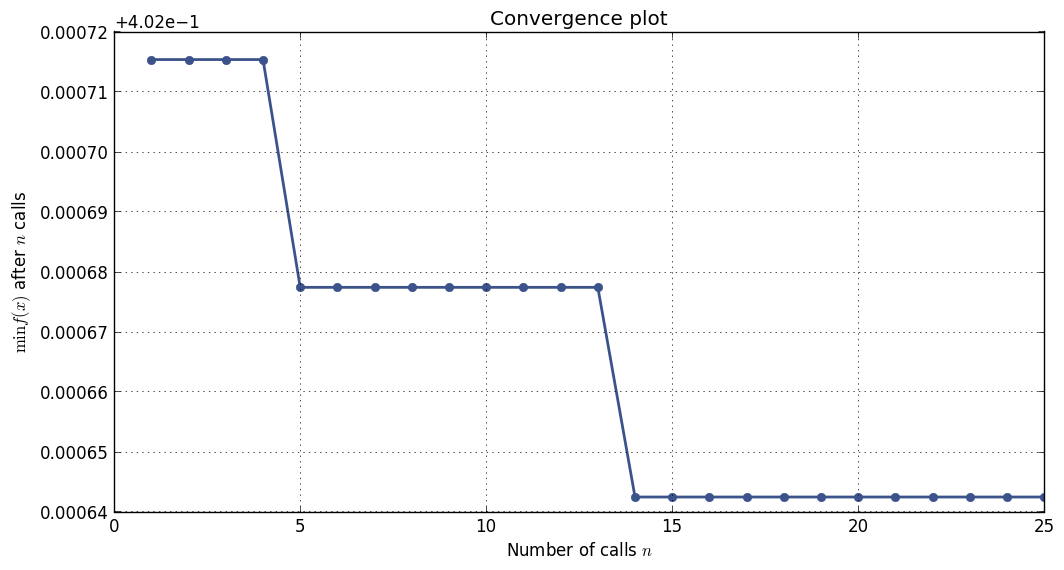

In [38]:
plotGPoptConvergence(res_gp)
plt.grid(True)
plt.show()

In [39]:
(best_C, ) = res_gp.x
best_C

18.197213630755986

In [40]:
%%time
clf = LogisticRegression(C=best_C)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.883215
f1_score_nondelayed        0.832412
f1_score_delayed           0.802244
f1_score_weighted_avg      0.817331
f1_score_unweighted_avg    0.817328
log_loss                   0.402642
accuracy_score             0.818605
dtype: float64
CPU times: user 8.24 s, sys: 6.21 s, total: 14.5 s
Wall time: 7.31 s


## K-Neighbors Classifier

In [25]:
%%time
clf = KNeighborsClassifier(n_neighbors=3, n_jobs=n_jobs)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.793938
f1_score_nondelayed        0.781561
f1_score_delayed           0.768018
f1_score_weighted_avg      0.774810
f1_score_unweighted_avg    0.774789
log_loss                   2.998314
accuracy_score             0.775027
dtype: float64
CPU times: user 14.9 s, sys: 284 ms, total: 15.2 s
Wall time: 7.41 s


In [26]:
def gpOptimization(n_jobs=n_jobs, n_folds=10):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (n_neighbors, ) = params
        print "current neighbors: {}".format(n_neighbors)
        start = time()

        clf = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=n_jobs)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    neighborsSpace = Integer(1, 100)
    space  = [neighborsSpace]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [27]:
res_gp = gpOptimization()

current neighbors: 45
current accuracy score: 0.799589976064
time elapsed: 9.93260502815

current neighbors: 48
current accuracy score: 0.800231176379
time elapsed: 10.0945110321

current neighbors: 65
current accuracy score: 0.796896321887
time elapsed: 10.2854669094

current neighbors: 68
current accuracy score: 0.795966577831
time elapsed: 12.7424390316

current neighbors: 68
current accuracy score: 0.795966577831
time elapsed: 10.64914608

current neighbors: 1
current accuracy score: 0.74337848618
time elapsed: 5.64970016479

current neighbors: 100
current accuracy score: 0.790483269892
time elapsed: 13.0908489227

current neighbors: 34
current accuracy score: 0.80087258235
time elapsed: 10.3664629459

current neighbors: 85
current accuracy score: 0.793754062964
time elapsed: 13.8688631058

current neighbors: 43
current accuracy score: 0.799878519805
time elapsed: 11.9620811939

current neighbors: 30
current accuracy score: 0.801385577564
time elapsed: 10.0708198547

current neighb

/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:195: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


current neighbors: 27
current accuracy score: 0.802123034533
time elapsed: 8.43398404121

current neighbors: 27
current accuracy score: 0.802123034533
time elapsed: 9.05366182327

current neighbors: 27
current accuracy score: 0.802123034533
time elapsed: 9.72579479218

current neighbors: 91
current accuracy score: 0.792407333562
time elapsed: 12.3854768276



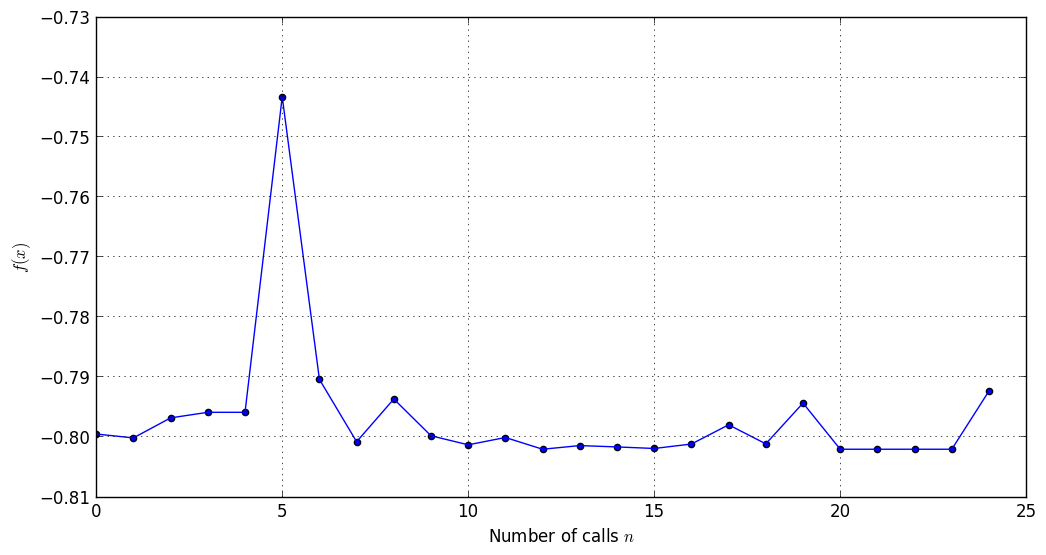

In [28]:
plotGPoptFunction(res_gp)
plt.grid(True)
plt.show()

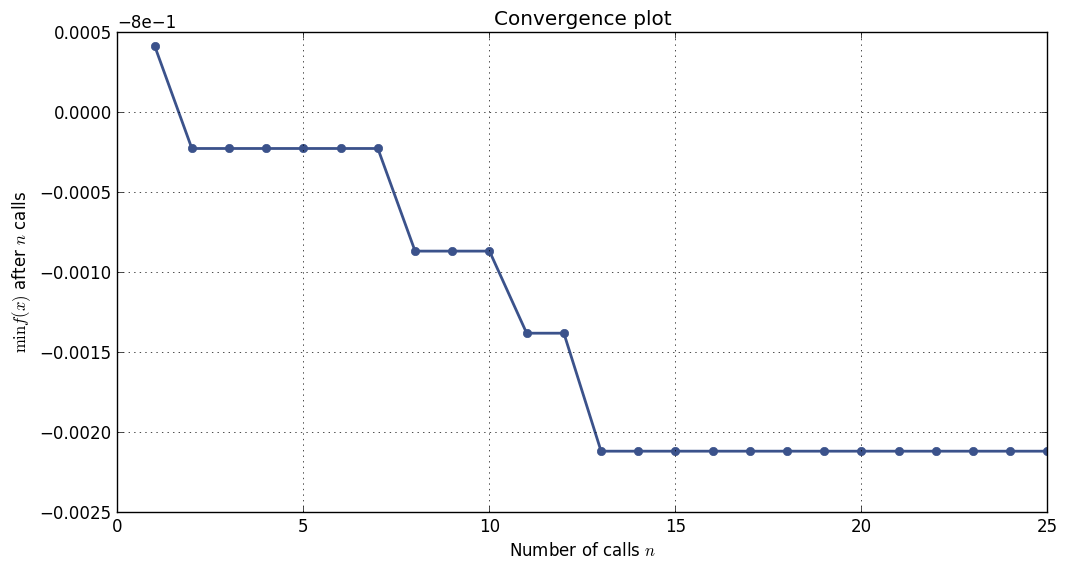

In [29]:
plotGPoptConvergence(res_gp)
plt.grid(True)
plt.show()

In [30]:
(best_n_neighbors, ) = res_gp.x
best_n_neighbors

27

In [31]:
%%time
clf = KNeighborsClassifier(n_neighbors=best_n_neighbors, n_jobs=n_jobs)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.865786
f1_score_nondelayed        0.817662
f1_score_delayed           0.783638
f1_score_weighted_avg      0.800649
f1_score_unweighted_avg    0.800650
log_loss                   0.456847
accuracy_score             0.802123
dtype: float64
CPU times: user 22.6 s, sys: 68 ms, total: 22.6 s
Wall time: 8.57 s


## Decision Tree Classifier

In [32]:
%%time
clf = DecisionTreeClassifier(max_depth=None)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.740017
f1_score_nondelayed        0.740137
f1_score_delayed           0.743281
f1_score_weighted_avg      0.741732
f1_score_unweighted_avg    0.741709
log_loss                   8.916364
accuracy_score             0.741743
dtype: float64
CPU times: user 3.28 s, sys: 4 ms, total: 3.29 s
Wall time: 3.29 s


In [33]:
def gpOptimization(n_jobs=n_jobs, n_folds=10):
    
    def objective(params): # Here we define the metric we want to minimise
        (max_depth, ) = params
        print "current depth: {}".format(max_depth)
        start = time()

        clf = DecisionTreeClassifier(max_depth=max_depth)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    max_depth_space = Integer(1, 100)
    space  = [max_depth_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [34]:
res_gp = gpOptimization()

current depth: 45
current accuracy score: 0.743185756936
time elapsed: 3.19530701637

current depth: 48
current accuracy score: 0.744308333064
time elapsed: 3.13128399849

current depth: 65
current accuracy score: 0.742095766784
time elapsed: 3.33486604691

current depth: 68
current accuracy score: 0.743314249954
time elapsed: 3.05344295502

current depth: 68
current accuracy score: 0.741358268684
time elapsed: 3.28596806526

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.528052091599

current depth: 100
current accuracy score: 0.74241632067
time elapsed: 5.04922795296

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.581784009933

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.952162027359

current depth: 10
current accuracy score: 0.801642049464
time elapsed: 2.93059206009

current depth: 1
current accuracy score: 0.812415936096
time elapsed: 0.584329843521

current depth: 1
current accuracy score: 0.81241593609

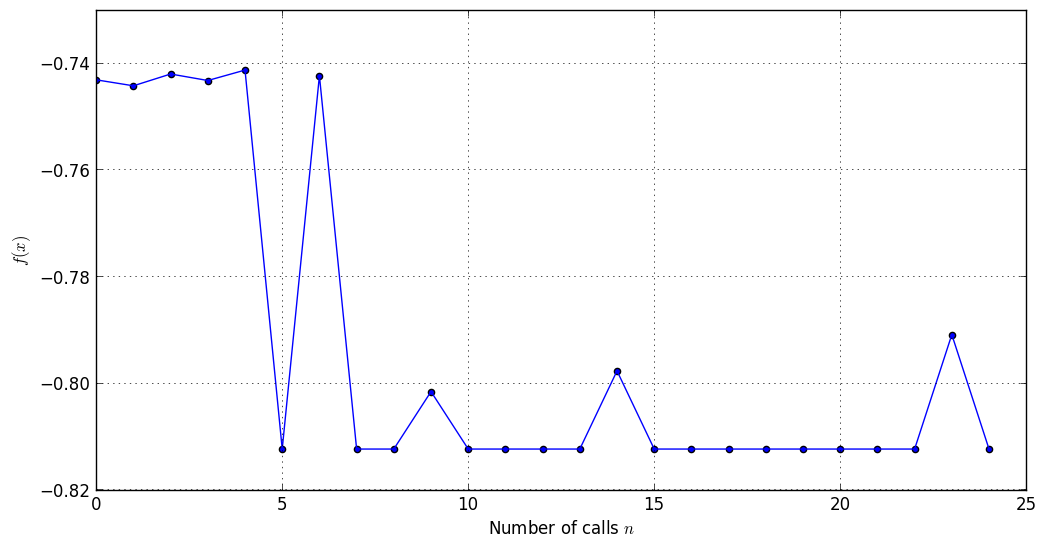

In [35]:
plotGPoptFunction(res_gp)
plt.grid(True)
plt.show()

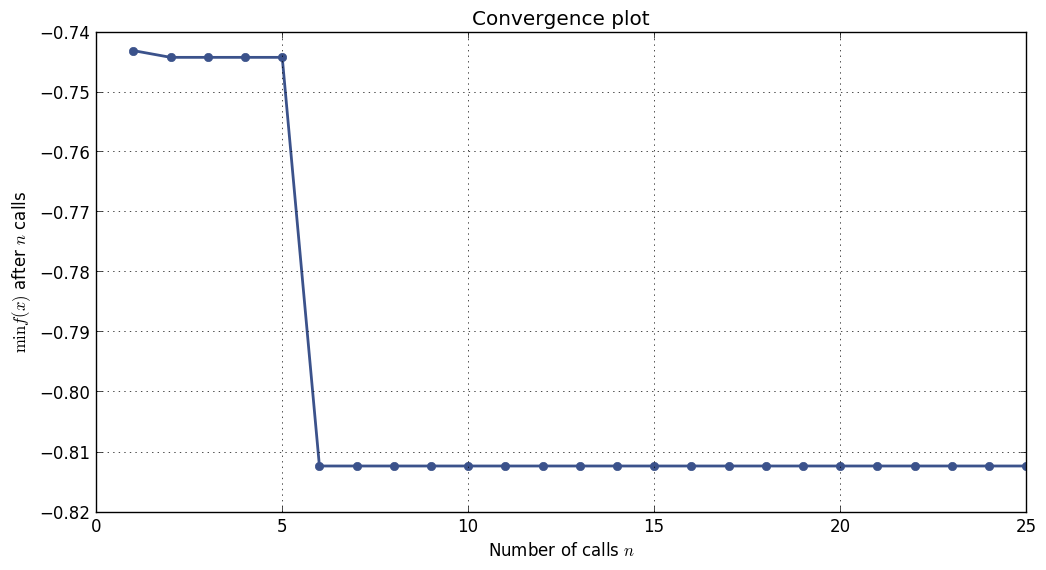

In [36]:
plotGPoptConvergence(res_gp)
plt.grid(True)
plt.show()

In [37]:
(best_max_depth, ) = res_gp.x
best_max_depth

1

In [38]:
%%time
clf = DecisionTreeClassifier(max_depth=best_max_depth)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.900854
f1_score_nondelayed        0.830753
f1_score_delayed           0.789529
f1_score_weighted_avg      0.810134
f1_score_unweighted_avg    0.810141
log_loss                   0.465058
accuracy_score             0.812416
dtype: float64
CPU times: user 528 ms, sys: 0 ns, total: 528 ms
Wall time: 528 ms


### log loss

In [39]:
def gpOptimization(n_jobs=1, n_folds=10):
    
    def objective(params): # Here we define the metric we want to minimise
        (max_depth, ) = params
        print "current depth: {}".format(max_depth)
        start = time()

        clf = DecisionTreeClassifier(max_depth=max_depth)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)

        scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
        score = scores['log_loss']
        print "current log loss: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        return score
    
    max_depth_space = Integer(1, 100)
    space  = [max_depth_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=25, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=5,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [40]:
res_gp = gpOptimization()

current depth: 45
current log loss: 8.83888529206
time elapsed: 3.40153598785

current depth: 48
current log loss: 8.82564797718
time elapsed: 3.09506607056

current depth: 65
current log loss: 8.83666488939
time elapsed: 3.36089897156

current depth: 68
current log loss: 8.89315923838
time elapsed: 3.13651895523

current depth: 68
current log loss: 8.82672259989
time elapsed: 3.20048093796

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.547179937363

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.545591115952

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.940181016922

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.941202878952

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.592287063599

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.592581987381

current depth: 1
current log loss: 0.465058178284
time elapsed: 0.59389090538

current depth: 1
current log loss: 0.465058178

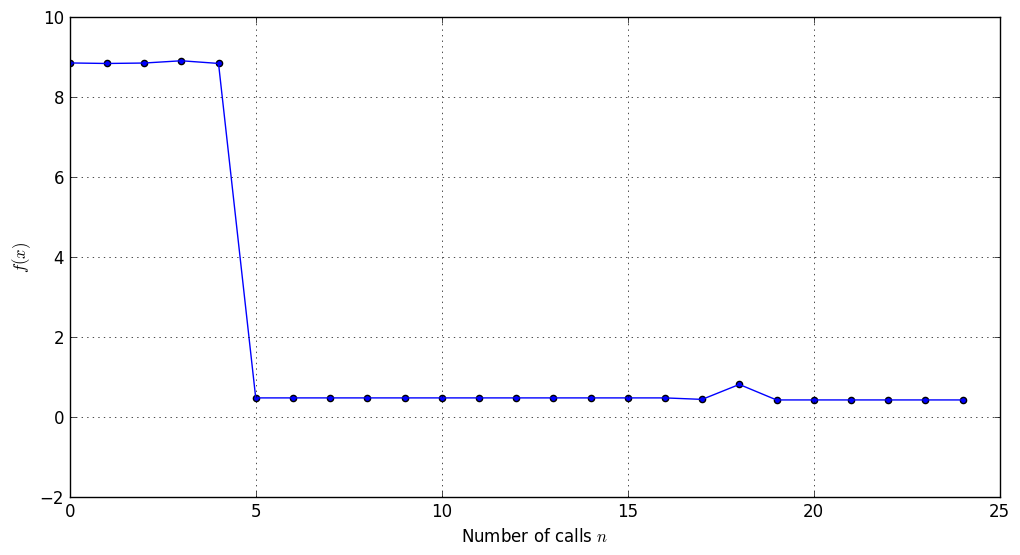

In [41]:
plotGPoptFunction(res_gp)
plt.grid(True)
plt.show()

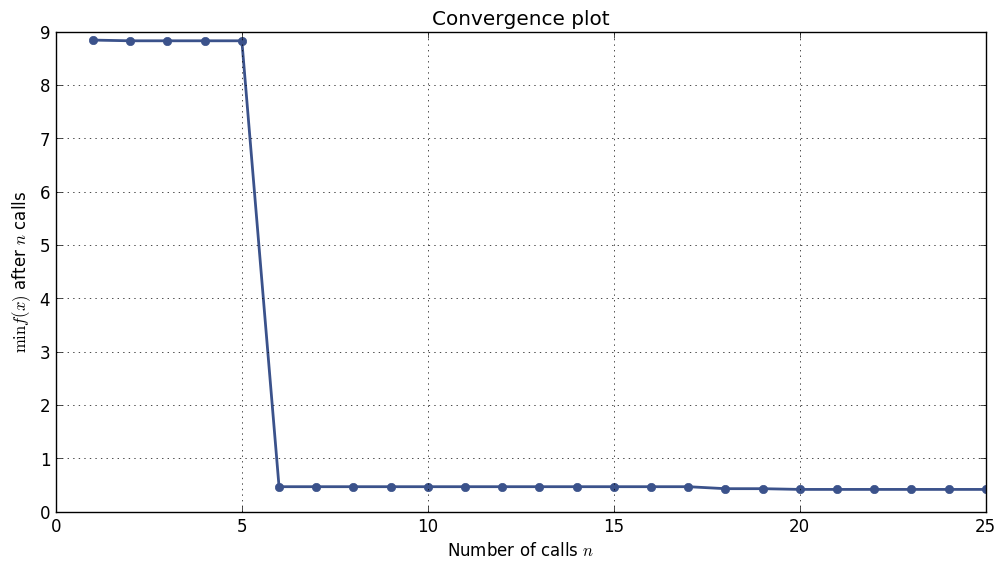

In [42]:
plotGPoptConvergence(res_gp)
plt.grid(True)
plt.show()

In [43]:
(best_max_depth, ) = res_gp.x
best_max_depth

3

In [44]:
%%time
clf = DecisionTreeClassifier(max_depth=best_max_depth)
cv = MyCrossValidation(n_folds=10, random_state=random_state)
scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
print scores

precision_score            0.854081
f1_score_nondelayed        0.823492
f1_score_delayed           0.803007
f1_score_weighted_avg      0.813267
f1_score_unweighted_avg    0.813250
log_loss                   0.414045
accuracy_score             0.813859
dtype: float64
CPU times: user 916 ms, sys: 0 ns, total: 916 ms
Wall time: 917 ms


## Linear Support Vector Classifier

In [45]:
# %%time
# clf = SVC(kernel='linear', probability=True)
# cv = MyCrossValidation(n_folds=2, random_state=random_state)
# scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
# print scores

In [46]:
def gpOptimization(n_jobs=n_jobs, n_folds=2):  # using all the features is too slow with any kind of neighbor
    
    def objective(params): # Here we define the metric we want to minimise
        (CC, ) = params
        print "current C: {}".format(CC)
        start = time()

        clf = SVC(kernel='linear', probability=False, C=CC)

        cv = MyCrossValidation(n_folds=n_folds, random_state=random_state)
        
        def onKFold_callback(cls):
            def score_onKFold(X_train, y_train, X_valid, y_valid, i):
                return pd.Series(data = cls.fit(X_train, y_train).score(X_valid, y_valid),
                                 name="accuracy_score").to_frame()
            return score_onKFold
        
        scores = cv.onEachKFold(XX, yy, onKFold_callback(clf))
        score = scores['accuracy_score']
        print "current accuracy score: {}".format(score)
        print "time elapsed: {}".format(time() - start)
        print

        # We want to maximise accuracy score, i.e. minimise minus average accuracy
        return -score
    
    C_space = Real(1e-4, 1e1, prior='log-uniform')
    space  = [C_space]
    
    return gp_minimize(
        func=objective, # function that we wish to minimise
        dimensions=space, #the search space for the hyper-parameters
        #x0=x0, #inital values for the hyper-parameters
        n_calls=10, #number of times the function will be evaluated
        random_state=random_state, #random seed
        n_random_starts=1,  #before we start modelling the optimised function with a GP Regression
                            #model, we want to try a few random choices for the hyper-parameters.
        kappa=1.9, #trade-off between exploration vs. exploitation.
        n_jobs=n_jobs
    )

In [47]:
#res_gp = gpOptimization()  #sorry but extremely slow

In [48]:
# plotGPoptFunction(res_gp)
# plt.grid(True)
# plt.show()

In [49]:
# plotGPoptConvergence(res_gp)
# plt.grid(True)
# plt.show()

In [50]:
# %%time
# (bestC, ) = res_gp.x
# print bestC
# clf = SVC(kernel='linear', probability=True, C=bestC)
# cv = MyCrossValidation(n_folds=2, random_state=random_state)
# scores = cv.onEachKFold(XX, yy, getScore_onKFold_callback(clf))
# print scores